# Setting up in Cybershuttle

In [1]:
%pip install -qU "airavata-python-sdk[notebook]"
import airavata_jupyter_magic

%authenticate
%request_runtime hpc_cpu --file=cybershuttle.yml --walltime=60 --use=NeuroData25VC1:cloud
%wait_for_runtime hpc_cpu --live
%switch_runtime hpc_cpu

Note: you may need to restart the kernel to use updated packages.

Loaded airavata_jupyter_magic (2.1.4.post4) 
(current runtime = local)

  %authenticate                              -- Authenticate to access high-performance runtimes.
  %request_runtime <rt> [args]               -- Request a runtime named <rt> with configuration <args>.
                                                Call multiple times to request multiple runtimes.
  %restart_runtime <rt>                      -- Restart runtime <rt> if it hangs. This will clear all variables.
  %stop_runtime <rt>                         -- Stop runtime <rt> when no longer needed.
  %wait_for_runtime <rt>                     -- Wait for runtime <rt> to be ready.
  %switch_runtime <rt>                       -- Switch the active runtime to <rt>. All subsequent cells will run here.
  %%run_on <rt>                              -- Force a cell to always execute on <rt>, regardless of the active runtime.
  %stat_runtime <rt>               

Output()

Authenticated.

Requesting runtime=hpc_cpu...
[NeuroData25VC1:cloud, 60 Minutes, 1 Node(s), 1 CPU(s), 0 GPU(s), 4096 MB RAM, 1024 MB VRAM]
* modules=[]
* libraries=['python=3.10', 'pip', 'ipywidgets', 'numpy', 'pandas', 'matplotlib', 'gxx_linux-64', 'scipy', 'h5py', 'plotly']
* pip=['nbformat']
* mounts=['bazhlab-whole-brain:/cybershuttle_data/bazhlab-whole-brain']
Requested runtime=hpc_cpu
Request successful: runtime=hpc_cpu


Output()

local:/var/folders/_n/fcf6nx4j67gbbt4_8mjqxdc80000gn/T/connection_22zxk2un.json --> hpc_cpu:connection_22zxk2un.json... [200]
started proc_name=hpc_cpu_kernel on rt=hpc_cpu. pid=3314
forwarding ports=[28470, 28471, 28472, 28473, 28474]
hpc_cpu:28470 -> access via 18.118.140.230:10000
hpc_cpu:28471 -> access via 18.118.140.230:10001
hpc_cpu:28472 -> access via 18.118.140.230:10002
hpc_cpu:28473 -> access via 18.118.140.230:10003
hpc_cpu:28474 -> access via 18.118.140.230:10004
started ipykernel tunnels for hpc_cpu at 18.118.140.230
started ipykernel client for hpc_cpu
Remote Jupyter kernel launched and connected for runtime=hpc_cpu.
Switched to runtime=hpc_cpu.


# Imports

In [2]:
# Imports
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
import pandas as pd
import h5py

# Plot settings
plt.rcParams.update({
    'axes.titlesize': 11,
    'axes.labelsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'lines.linewidth': 0.8
})

# Flags
figs_only = False
load_data = True
load_soprops = True
intermediate_plots = False


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


# Read simulation results

In [3]:
# Load parcels (CSV expected to have a single column of 10242 values)
parc = pd.read_csv('cybershuttle_data/bazhlab-whole-brain/analysis/files/parcels.csv', header=None).values.flatten()

# Get indices of non-medial wall (non-zero values)
idx = np.arange(1, 10243)  # MATLAB 1-based index range
idx_ml = np.where(parc == 0)[0]
idx_nml = np.setdiff1d(idx, idx_ml + 1) - 1  # shift to 0-based
n_nml = len(idx_nml)

# Load surface structure
surf_data = sio.loadmat('cybershuttle_data/bazhlab-whole-brain/analysis/files/ico5_pial_surf_lh.mat', struct_as_record=False, squeeze_me=True)
srf = surf_data['srf']


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [4]:
so_props = sio.loadmat('cybershuttle_data/bazhlab-whole-brain/sim_files/so_SO_base.mat')
with h5py.File('cybershuttle_data/bazhlab-whole-brain/sim_files/time_cx_SO_base.mat', 'r') as f:
    data = {key: np.array(f[key]) for key in f.keys()}
time_cx = data['time_cx']

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


# Analyze Simulation Results

In [5]:
# Duration of interest
td = 30000  # in milliseconds
time_vector = np.linspace(0, td, td)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


In [6]:
# Remove medial wall
time_cx_nml = time_cx[:, idx_nml].T

# Compute average voltage
time_cx_mean = np.nanmean(time_cx_nml, axis=0)
print("Mean voltage shape:", time_cx_mean.shape)

# --- SO peak/min detection ---
from scipy.signal import find_peaks

prominence = (np.nanmax(time_cx_mean) - np.nanmin(time_cx_mean)) / 2
pksep = 500  # min separation in samples

peaks_idx, _ = find_peaks(time_cx_mean, prominence=max(1, prominence), distance=pksep)
peaks = time_cx_mean[peaks_idx]
npeaks = len(peaks)

# Find local minima between peaks
mins = []
locs_mins = []
t0 = 0
for peak_idx in peaks_idx:
    segment = time_cx_mean[t0:peak_idx]
    min_val = np.min(segment)
    min_pos = np.where(segment == min_val)[0][0] + t0
    mins.append(min_val)
    locs_mins.append(min_pos)
    t0 = peak_idx

# Final segment
final_segment = time_cx_mean[t0:]
min_val = np.min(final_segment)
min_pos = np.where(final_segment == min_val)[0][0] + t0
mins.append(min_val)
locs_mins.append(min_pos)

mins = np.array(mins)
locs_mins = np.array(locs_mins)

# Inter-peak stats
interpeak = np.diff(peaks_idx)
so_freq_direct = 1000 / np.mean(interpeak)
so_freq = 1000 / interpeak
so_freq_mean = np.mean(so_freq)
so_freq_sd = np.std(so_freq)

# Amplitudes
if len(peaks) == len(mins):
    amp = peaks - mins
elif len(peaks) > len(mins):
    amp = peaks[1:] - mins
else:
    amp = peaks - mins[1:]

amp_mean = np.mean(amp)
amp_sd = np.std(amp)


executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
Mean voltage shape: (30000,)
cell finished on hpc_cpu.


### Detect UP and DOWN states

In [7]:
# Thresholds from Komarov (2017)
thr_down = -68
thr_up = -65

t_cx_bin_up = time_cx > thr_up
t_cx_bin_down = time_cx < thr_down

def clean_onoff(binary_matrix, min_len):
    cleaned = np.copy(binary_matrix)
    for i in range(binary_matrix.shape[0]):
        row = binary_matrix[i, :]
        diff = np.diff(np.concatenate([[0], row, [0]]))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        for s, e in zip(starts, ends):
            if e - s < min_len:
                cleaned[i, s:e] = 0
    return cleaned

print("Cleaning upstates...")
t_cx_bin_up_cl = clean_onoff(t_cx_bin_up, min_len=100)

print("Cleaning downstates...")
t_cx_bin_down_cl = clean_onoff(t_cx_bin_down, min_len=100)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
Cleaning upstates...
Cleaning downstates...
cell finished on hpc_cpu.


In [8]:
nmins = len(mins)
n_neurons = time_cx.shape[0]

onset_diffs = np.full((n_neurons, nmins-1), np.nan)
offset_diffs = np.full((n_neurons, nmins-1), np.nan)

def onoffdiff(wave_up, wave_down, min_len):
    n, t = wave_up.shape
    diff_on = np.full(n, np.nan)
    diff_off = np.full(n, np.nan)
    for i in range(n):
        up_times = np.where(wave_up[i])[0]
        down_times = np.where(wave_down[i])[0]
        if len(up_times) > 0:
            diff_on[i] = up_times[0]
        if len(down_times) > 0:
            diff_off[i] = down_times[-1]
    return diff_on, diff_off

for j in range(nmins-1):
    tw0 = max(locs_mins[j] - 100, 0)
    tw1 = locs_mins[j + 1]
    wave_up = t_cx_bin_up_cl[:, tw0:tw1]
    wave_dn = t_cx_bin_down_cl[:, tw0:tw1]

    diff_on, diff_off = onoffdiff(wave_up, wave_dn, min_len=100)
    onset_diffs[:, j] = diff_on
    offset_diffs[:, j] = diff_off

onset_diffs_sd = np.nanstd(onset_diffs)
offset_diffs_sd = np.nanstd(offset_diffs)

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
cell finished on hpc_cpu.


# Plot results

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...
Plotting summary figure...


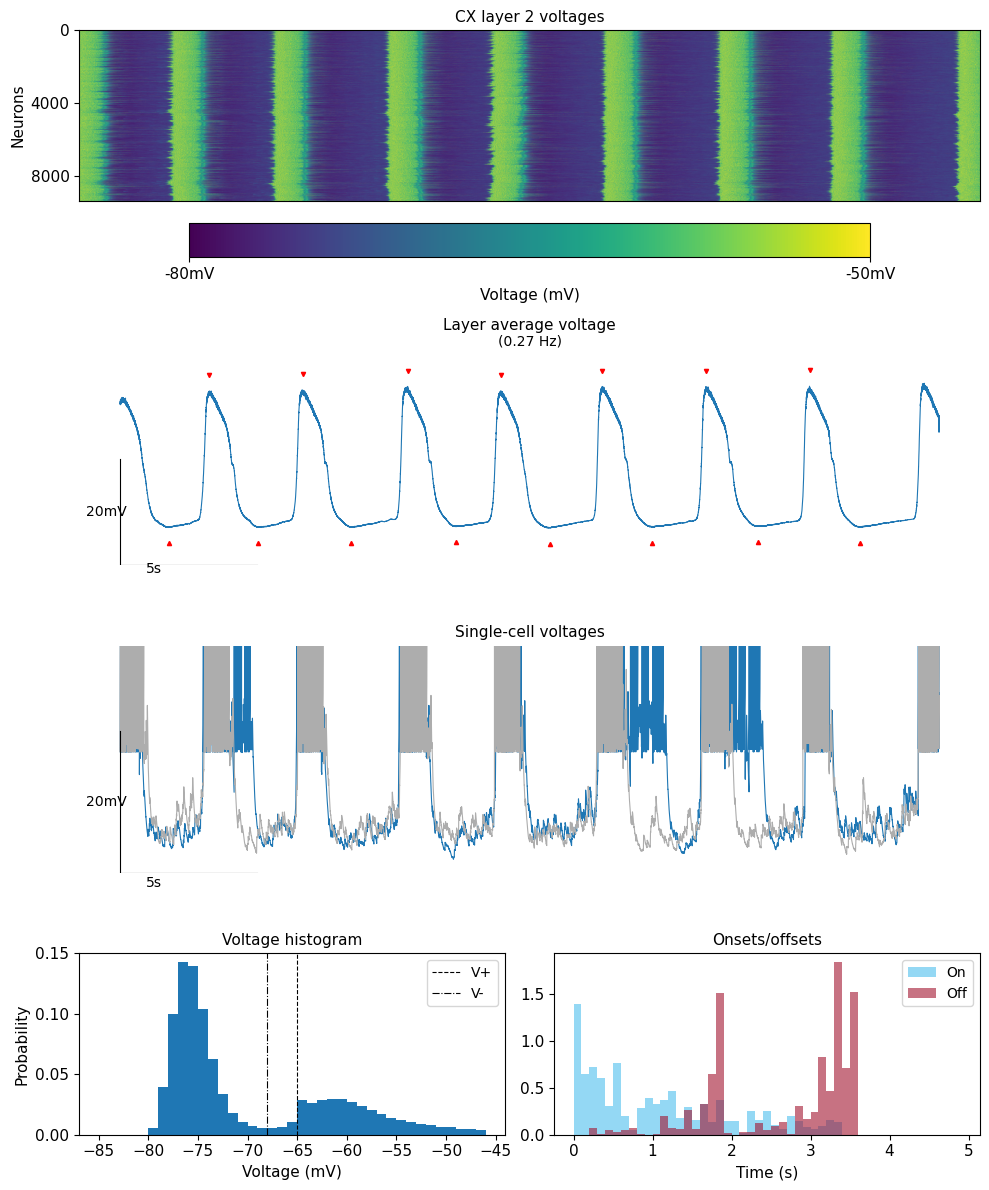

cell finished on hpc_cpu.


In [9]:
import matplotlib.gridspec as gridspec

print("Plotting summary figure...")
fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 0.8])
xticks_ms = np.arange(0, td+1, 5000)
xtick_labels = (xticks_ms / 1000).astype(int).astype(str)

# 1. Heatmap of CX L2 voltages
ax0 = fig.add_subplot(gs[0, :])
cmap = plt.get_cmap("viridis")
vmin, vmax = -80, -50

im = ax0.imshow(time_cx_nml, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, ax=ax0, orientation='horizontal', pad=0.1)
cb.set_label('Voltage (mV)')
cb.set_ticks([vmin, vmax])
cb.set_ticklabels([f'{vmin}mV', f'{vmax}mV'])
ax0.set_title('CX layer 2 voltages')
ax0.set_ylabel('Neurons')
ax0.set_yticks(np.arange(0, n_nml, 4000))
#ax0.set_yticklabels((np.arange(0, n_nml, 4000) / 1000).astype(int).astype(str) + ['k'])
ax0.set_xticks([])

# 2. Average voltage with peaks/mins
ax1 = fig.add_subplot(gs[1, :])
ax1.plot(time_vector, time_cx_mean, label='Mean voltage')
ax1.plot(time_vector[peaks_idx], peaks + 3, 'vr', label='Peaks', markersize=3)
ax1.plot(time_vector[locs_mins], mins - 3, '^r', label='Mins', markersize=3)

ax1.set_title("Layer average voltage")
ax1.set_ylim([-83, -40])
ax1.axis('off')

# Add scales
scale_t = 5000  # ms
scale_y = 20    # mV
ax1.plot([0, scale_t], [-83, -83], 'k')
ax1.plot([0, 0], [-83, -63], 'k')
ax1.text(scale_t / 4, -84.5, f"{scale_t//1000}s", ha='center')
ax1.text(-scale_t * 0.25, -73, f"{scale_y}mV", va='center')

# Add SO stats
txt = f"({so_freq_mean:.2f} Hz)"
ax1.text(time_vector.max() / 2, -41.5, txt, ha='center')

# 3. Single cell voltages
ax2 = fig.add_subplot(gs[2, :])
c1, c2 = 1006, 928
ax2.plot(time_vector, time_cx[:,c1], label=f"Cell {c1}")
ax2.plot(time_vector, time_cx[:,c2], label=f"Cell {c2}", color=[0.68]*3)
ax2.set_ylim([-82, -50])
ax2.set_title("Single-cell voltages")
ax2.axis('off')
ax2.plot([0, scale_t], [-82, -82], 'k')
ax2.plot([0, 0], [-82, -62], 'k')
ax2.text(scale_t / 4, -84, f"{scale_t//1000}s", ha='center')
ax2.text(-scale_t * 0.25, -72, f"{scale_y}mV", va='center')

# 4. Voltage histogram
ax3 = fig.add_subplot(gs[3, 0])
flat_voltages = time_cx_nml.flatten()
flat_voltages = flat_voltages[~np.isnan(flat_voltages)]
h = ax3.hist(flat_voltages, bins=np.arange(-85, -45, 1), density=True)
ax3.axvline(thr_up, linestyle='--', color='k', label='V+')
ax3.axvline(thr_down, linestyle='-.', color='k', label='V-')
ax3.set_title("Voltage histogram")
ax3.set_xlabel("Voltage (mV)")
ax3.set_ylabel("Probability")
ax3.legend()

# 5. Onset/offset histograms
ax4 = fig.add_subplot(gs[3, 1])
onset_sec = onset_diffs[~np.isnan(onset_diffs)] * 0.001
offset_sec = offset_diffs[~np.isnan(offset_diffs)] * 0.001

h1 = ax4.hist(onset_sec, bins=np.arange(0, 5, 0.1), density=True, alpha=0.6, label='On', color='#4DBEEE')
h2 = ax4.hist(offset_sec, bins=np.arange(0, 5, 0.1), density=True, alpha=0.6, label='Off', color='#A2142F')

ax4.set_title("Onsets/offsets")
ax4.set_xlabel("Time (s)")
ax4.legend()

plt.tight_layout()
#plt.show()


# Examine individual neurons

executing cell on hpc_cpu...
waiting for cell to finish on hpc_cpu...


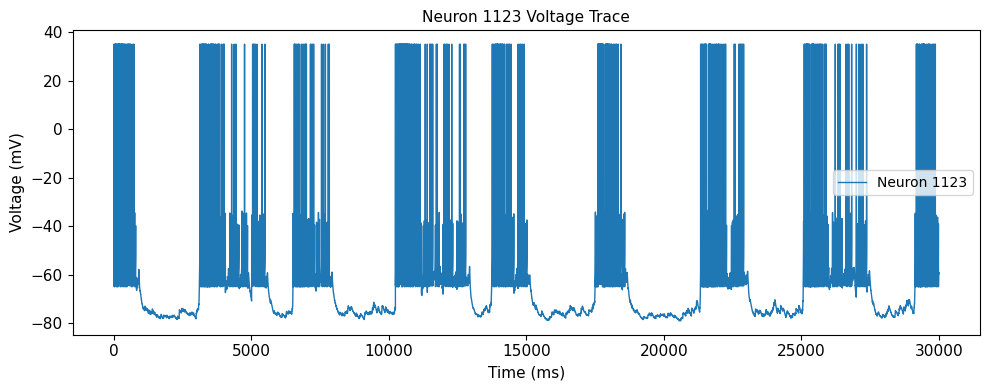

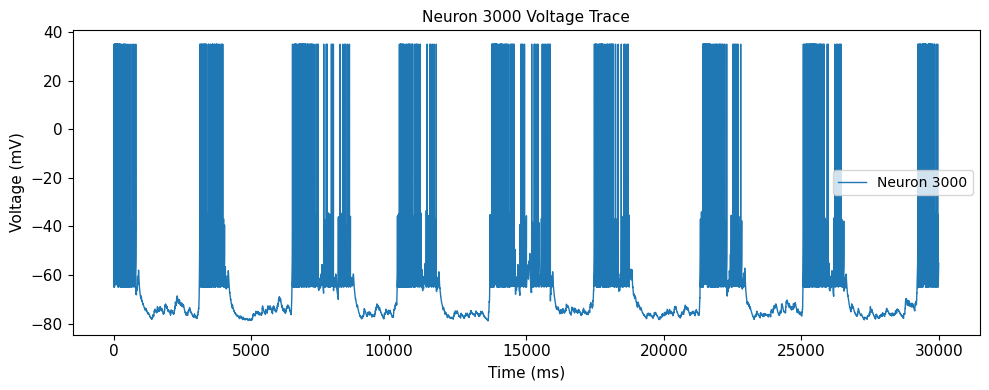

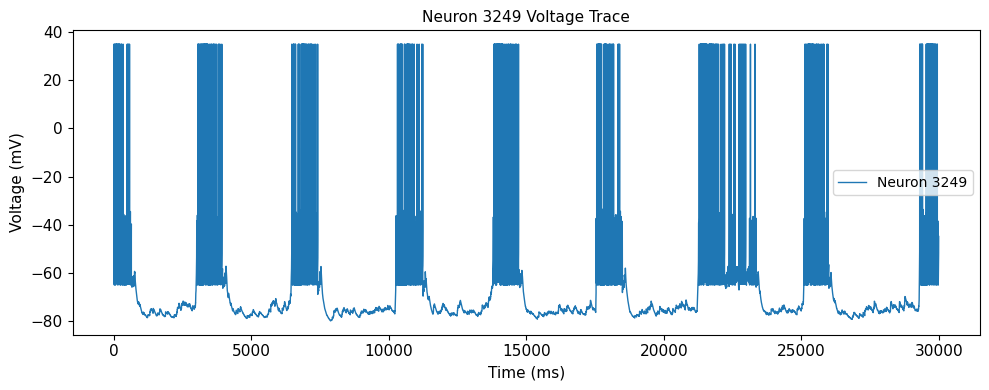

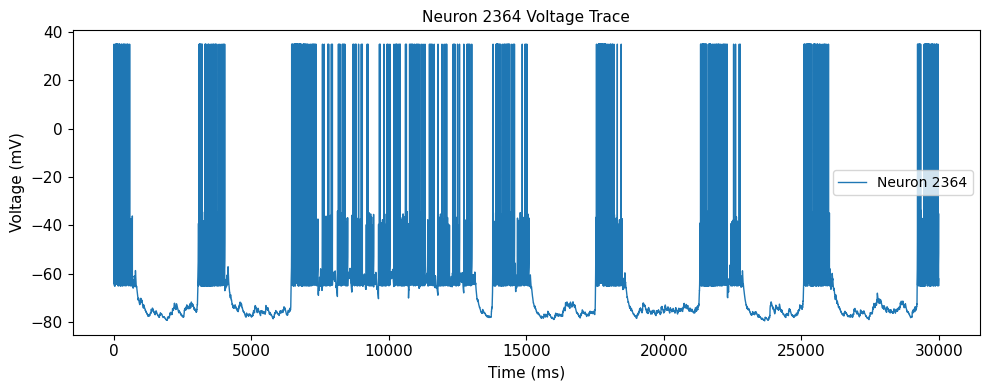

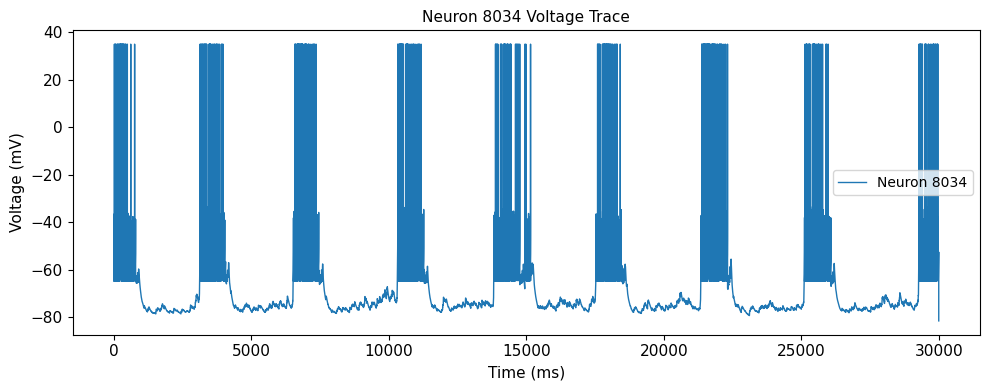

cell finished on hpc_cpu.


In [10]:
def plot_single_cell(cell_idx):
    plt.figure(figsize=(10, 4))  # width x height in inches
    plt.plot(time_vector, time_cx_nml[cell_idx, :], linewidth=1, label=f'Neuron {cell_idx}')
    plt.title(f'Neuron {cell_idx} Voltage Trace')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Pick 5 random unique neuron indices
num_neurons = time_cx_nml.shape[0]
random_indices = np.random.choice(num_neurons, size=5, replace=False)

# Plot the randomly selected neurons
for idx in random_indices:
    plot_single_cell(idx)

In [11]:
%stop_runtime hpc_cpu

Terminated runtime=hpc_cpu. state={'experimentId': 'CS_Agent_ab6c98c6-e8a2-4f48-9842-85cf73753d69', 'terminated': True}
